In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import distance_matrix

sns.set(style='whitegrid', font='serif')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
towns = np.loadtxt('/content/drive/My Drive/data/tsp.csv', delimiter=",", usecols=range(1, 3))
distances = distance_matrix(towns, towns, p=1)

In [0]:
def visualize(towns):
    plt.scatter(towns[:,0], towns[:,1])
    for town1, town2 in zip(towns, towns[1:]):
        plt.plot([town1[0], town1[0], town2[0]], [town1[1], town2[1], town2[1]])
    plt.show()

def calc_perm_dist(distances, perm):
    return np.sum([distances[x1, x2] for x1, x2 in zip(perm, perm[1:])])



## 1. (1 балл) Реализуйте Монте-Карло поиск.

27505.0


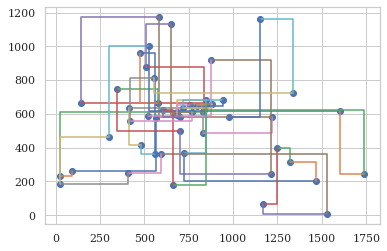

In [5]:
def monte_carlo(distances, tries=300000):
    n, _ = distances.shape
    best_perm, best_dist = None, 1e12

    for _ in range(tries):
        perm = np.random.permutation(n)
        dist = calc_perm_dist(distances, perm)
        if dist < best_dist:
            best_dist, best_perm = dist, perm

    return best_perm, best_dist

best_perm, best_dist = monte_carlo(distances)
print(best_dist)
visualize(towns[best_perm])


## 2. (1 балл) Реализуйте поиск случайным блужданием.

26470.0


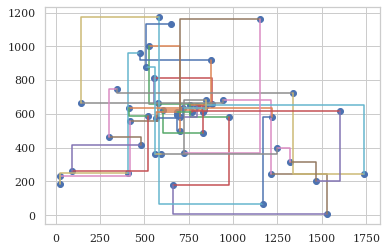

In [6]:
def mutate_perm_random_pair(perm):
    new_perm = perm.copy()
    i1, i2 = np.random.choice(len(perm), size=2, replace=False)
    new_perm[i1], new_perm[i2] = new_perm[i2], new_perm[i1]
    return new_perm

def random_walk(distances, walkers=30, walk_length=10000):
    n, _ = distances.shape
    best_perm, best_dist = None, 1e12
    
    for _ in range(walkers):
        perm = np.random.permutation(n)
        for _ in range(walk_length):
            perm = mutate_perm_random_pair(perm)
            dist = calc_perm_dist(distances, perm)
            if dist < best_dist:
                best_dist, best_perm = dist, perm

    return best_perm, best_dist

best_perm, best_dist = random_walk(distances)
print(best_dist)
visualize(towns[best_perm])

## 3. (2 балла) Реализуйте Hill Climb.

11820.0


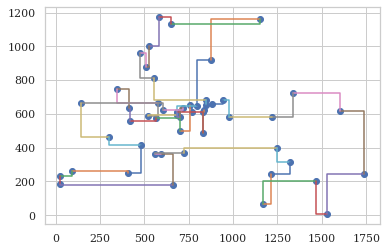

In [7]:
def hill_climb(distances, climbers=10, check_mutations=30, climb_length=1000):
    n, _ = distances.shape
    best_perm, best_dist = None, 1e12
    
    for _ in range(climbers):
        perm = np.random.permutation(n)
        for _ in range(climb_length):
            best_perm_mutation, best_dist_mutation = None, 1e12

            new_perms = [mutate_perm_random_pair(perm) for _ in range(check_mutations)]
            dists = [calc_perm_dist(distances, perm) for perm in new_perms]
            perm = new_perms[np.argmin(dists)]
        
        dist = calc_perm_dist(distances, perm)
        if dist < best_dist:
            best_dist, best_perm = dist, perm

    return best_perm, best_dist

best_perm, best_dist = hill_climb(distances)
print(best_dist)
visualize(towns[best_perm])

## (3 балла) Реализуйте ожиг (simulated annealing). Температурный режим отжига выберите самостоятельно.


11820.0


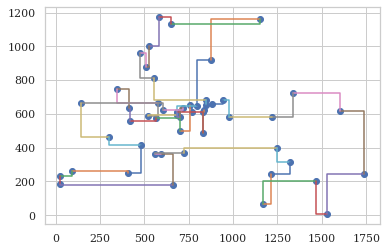

In [8]:
def burning(distances, length=10000, check_mutations=30, min_t=0.0001, max_t=10):
    n, _ = distances.shape
    
    perm = np.random.permutation(n)
    for t in np.linspace(max_t, min_t, length):
        new_perms = [mutate_perm_random_pair(perm) for _ in range(check_mutations)]
        dists = np.array([calc_perm_dist(distances, perm) for perm in new_perms])

        ps = np.exp(dists / dists.sum() / t)
        i = np.random.choice(len(ps), 1, p=ps / ps.sum())[0]
        perm = new_perms[i]

    return best_perm, best_dist

best_perm, best_dist = burning(distances)
print(best_dist)
visualize(towns[best_perm])

## 5. (3 балла) Реализуйте генетический алгоритм. 

11360.0


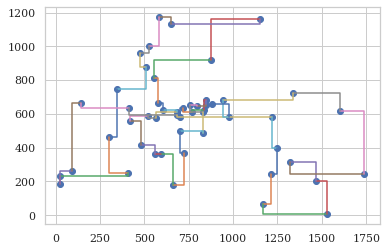

In [9]:
def cross(perm1, perm2):
    # in O(n)
    def get_order_from_subperm(subperm):
        arr = np.zeros(n, dtype=int)
        arr[subperm] += 1
        return np.cumsum(arr)[subperm] - 1

    n = len(perm1)
    i1, i2 = sorted(np.random.choice(n, size=2, replace=False))
    
    new_order = get_order_from_subperm(np.append(perm1[:i1], perm1[i2:]))
    middle = perm2[i1:i2]
    not_middle = np.sort(np.append(perm2[:i1], perm2[i2:]))

    return np.concatenate([not_middle[new_order[:i1]], middle, not_middle[new_order[i1:]]])

def evolution(distances, populations_count=42, permutations_count=10, steps=300000):
    n, _ = distances.shape
    populations = [[np.random.permutation(n) for _ in range(permutations_count)] for _ in range(populations_count)]

    for _ in range(steps):
        pop_index = np.random.randint(0, populations_count)

        i1, i2, i3 = np.random.choice(permutations_count, size=3, replace=False)
        perm1, perm2, perm3 = populations[pop_index][i1], populations[pop_index][i2], populations[pop_index][i3]

        # cross
        new_perm = cross(perm1, perm2)
        if calc_perm_dist(distances, new_perm) < calc_perm_dist(distances, perm1):
            populations[pop_index][i1] = new_perm

        # mutation
        new_perm = mutate_perm_random_pair(perm3)
        if calc_perm_dist(distances, new_perm) < calc_perm_dist(distances, perm3):
            populations[pop_index][i3] = new_perm

    perms = [perm for population in populations for perm in population]
    dists = np.array([calc_perm_dist(distances, perm) for perm in perms])
    min_i = np.argmin(dists)

    return perms[min_i], dists[min_i]

np.random.seed(42)
best_perm, best_dist = evolution(distances)
print(best_dist)
visualize(towns[best_perm])